In [3]:
import hyperimp.evaluate.importance as hyperimp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import openml
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')

In [4]:
# load traces
with open('01 data/exp2/trace_data.pickle', 'rb') as handle:
     traces = pickle.load(handle)

# load accuracy data
with open('01 data/exp2/acc_data.pickle', 'rb') as handle:
     data = pickle.load(handle)
        
# remove datasets for which accuracy = 1 in non-fixed situation
data_tun = data[~data['task'].isin(['11', '10093', '49'])]

# Average rank

In [3]:
# compute ranks
ranks = {}
for parameter in ['min_samples_split', 'criterion', 'max_features', 'min_samples_leaf', 'bootstrap',
                 'gamma', 'C', 'shrinking', 'tol']:
    print(parameter)
    if parameter in ['max_features', 'gamma']:
        deftypes = ['sklearn', 'hyperimp']
    else:
        deftypes = ['None']
    if parameter in ['min_samples_split', 'criterion', 'max_features', 'min_samples_leaf', 'bootstrap']:
        classifier = 'random_forest'
    if parameter in ['gamma', 'C', 'shrinking', 'tol']:
        classifier = 'svm'
    for deftype in deftypes:
        nf_ranks_tot = 100 * [0]
        f_ranks_tot = 100 * [0]
        nf_ranks_sumsq = 100 * [0]
        f_ranks_sumsq = 100 * [0]
        num = 0
        for task in data['task'].unique():
            for seed in data['seed'].unique():
                nf_runid = list(data[(data['parameter'] == 'None') & (data['task'] == task) &
                                  (data['seed'] == seed) & (data['classifier'] == classifier)]['run_id'])[0]
                f_run = list(data[(data['parameter'] == parameter) & (data['task'] == task) &
                              (data['seed'] == seed) & (data['classifier'] == classifier) &
                                 (data['deftype'] == deftype)]['run_id'])
                if len(f_run) == 1:
                    f_runid = f_run[0]
                else:
                    break
                nf_ranks = []
                f_ranks = []
                for nf, f in zip(traces[nf_runid], traces[f_runid]):
                    if nf > f:
                        rank_nf = 1
                        rank_f = 2
                    elif f > nf:
                        rank_f = 1
                        rank_nf = 2
                    elif nf == f:
                        rank_f = 1.5
                        rank_nf = 1.5
                    nf_ranks.append(rank_nf)
                    f_ranks.append(rank_f)
                nf_ranks_sumsq = np.add(nf_ranks_sumsq, np.power(nf_ranks, 2))
                f_ranks_sumsq = np.add(f_ranks_sumsq, np.power(f_ranks, 2))
                nf_ranks_tot = np.add(nf_ranks_tot, nf_ranks)
                f_ranks_tot = np.add(f_ranks_tot, f_ranks)
                num += 1
        nf_ranks_avg = nf_ranks_tot/num
        f_ranks_avg = f_ranks_tot/num
        nf_ranks_std = np.sqrt(np.subtract(nf_ranks_sumsq/num, np.power(nf_ranks_avg,2)))
        f_ranks_std = np.sqrt(np.subtract(f_ranks_sumsq/num, np.power(f_ranks_avg,2)))
        ranks[(parameter, deftype)] = {'nf_avg' : nf_ranks_avg, 'f_avg' : f_ranks_avg,
                                       'nf_std' : nf_ranks_std, 'f_std' : f_ranks_std}

min_samples_split
criterion
max_features
min_samples_leaf
bootstrap
gamma
C
shrinking
tol


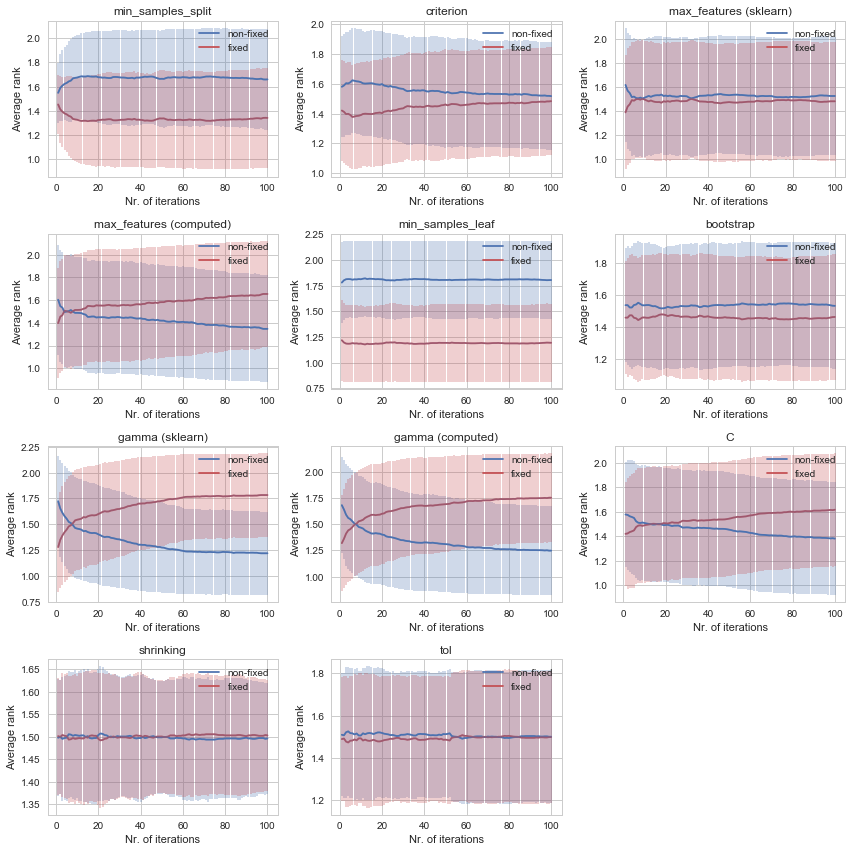

In [4]:
grid = True # put images on grid or not

if grid:
    cols = 3
    rows = 4
    plt.figure(figsize = (4*cols,3*rows))
    index = 0
    
for key, value in ranks.items():
    if grid:
        index += 1
        plt.subplot(rows, cols, index)
    nf = plt.plot(range(1,101), value['nf_avg'], label = 'non-fixed', color = sns.color_palette()[0])
    f = plt.plot(range(1,101), value['f_avg'], label = 'fixed', color = sns.color_palette()[2])
    plt.errorbar(range(1,101), value['nf_avg'], yerr=value['nf_std'], fmt='-', alpha = 0.3, ecolor = nf[0].get_color())
    plt.errorbar(range(1,101), value['f_avg'], yerr=value['f_std'], fmt='-', alpha = 0.3, ecolor = f[0].get_color())
    #plt.plot(value['nf_avg'], label = 'non-fixed')
    #plt.plot(value['f_avg'], label = 'fixed')
    plt.xlabel("Nr. of iterations")
    plt.ylabel("Average rank")
    plt.legend()
    if key[0] == 'max_features' or key[0] == 'gamma':
        subtitle = key[1]
        if key[1] == 'hyperimp':
            subtitle = 'computed'
        title = '%s (%s)' % (key[0], subtitle)
    else:
        title = key[0]
    plt.title(title)
    plt.tight_layout()
    if not grid:
        plt.savefig('02 figures/ranks/ranks__%s__%s.pdf' % (key[0], key[1]), format = 'pdf')
        plt.show()
if grid:
    plt.show()

# Tunability


In [5]:
# Compute risk scores for non-fixed condition
non_fixed_dict = {}
for task in data_tun['task'].unique():
    for seed in data_tun['seed'].unique():
        for classifier in ['random_forest', 'svm']:
            record = data_tun[(data_tun['parameter'] == 'None') & (data_tun['task'] == task) &
                          (data_tun['seed'] == seed) & (data_tun['classifier'] == classifier)]
            if len(record) == 1:
                non_fixed_risk = 1 - list(record['acc_openml'])[0]
            else:
                non_fixed_risk = None
                print('No data found for task %s, seed %s, classifier %s' %(task, seed, classifier))
            non_fixed_dict[(task, seed, classifier)] = non_fixed_risk

In [6]:
# Create lists of paired risks for each hyperparameter: ALL DATASETS
risks = {}
for parameter in ['min_samples_split', 'criterion', 'max_features', 'min_samples_leaf', 
                  'bootstrap', 'gamma', 'shrinking', 'tol', 'C']:
    if parameter in ['min_samples_split', 'criterion', 'max_features', 'min_samples_leaf', 'bootstrap']:
        classifier = 'random_forest'
    elif parameter in ['gamma', 'shrinking', 'tol', 'C']:
        classifier = 'svm'
    if parameter in ['max_features', 'gamma']:
        deftypes = ['sklearn', 'hyperimp']
    else: 
        deftypes = ['None']
    for deftype in deftypes:
        fixed = []
        non_fixed = []
        for task in data_tun['task'].unique():
            for seed in data_tun['seed'].unique():
                record = data_tun[(data_tun['parameter'] == parameter) & (data_tun['task'] == task) &
                              (data_tun['seed'] == seed) & (data_tun['deftype'] == deftype)]
                if len(record) == 1:
                    fixed_risk = 1 - list(record['acc_openml'])[0]
                    non_fixed_risk = non_fixed_dict[(task, seed, classifier)]
                    fixed.append(fixed_risk)
                    non_fixed.append(non_fixed_risk)
                else:
                    print('Error for parameter %s, task %s, seed %s, deftype %s.' % (parameter, task, seed, deftype))
        risk_parameter = {'fixed' : fixed, 'non_fixed' : non_fixed}
        risks[(parameter, deftype)] = risk_parameter

In [7]:
all_scores = []
all_scores_rel = []
parameters = []

tunabilities = {}
for key, risk in risks.items():
    fixed = risk['fixed']
    non_fixed = risk['non_fixed']
    scores = hyperimp.tunability(fixed, non_fixed)
    scores_rel = hyperimp.relative_tunability(fixed, non_fixed)
    scores_rel = [x for x in scores_rel if not np.isnan(x)]
    parameter = key[0]
    if parameter == 'max_features' or parameter == 'gamma':
        if key[1] == 'sklearn':
            parameter = parameter = '%s (%s)' % (key[0], key[1])
    parameters.append(parameter)
    tunabilities[key] = {
        'avg. tunability' : np.mean(scores),
        'std. tunability' : np.std(scores),
        'avg. rel. tunability' : np.mean(scores_rel),
        'std. rel. tunability' : np.std(scores_rel)}
    all_scores.append(scores)
    all_scores_rel.append(scores_rel)
    
pd.options.display.float_format = '{:,.4f}'.format
display(pd.DataFrame(tunabilities).transpose()[['avg. tunability', 'std. tunability', 
                                               'avg. rel. tunability', 'std. rel. tunability']])
pd.reset_option('float_format')

avg. tunability  std. tunability  \
C                 None               0.0008           0.0062   
bootstrap         None              -0.0002           0.0053   
criterion         None              -0.0002           0.0040   
gamma             hyperimp           0.0177           0.0594   
                  sklearn            0.0039           0.0114   
max_features      hyperimp           0.0011           0.0068   
                  sklearn            0.0009           0.0133   
min_samples_leaf  None              -0.0029           0.0076   
min_samples_split None              -0.0009           0.0047   
shrinking         None              -0.0000           0.0005   
tol               None              -0.0001           0.0016   

                            avg. rel. tunability  std. rel. tunability  
C                 None                    0.0246                0.2393  
bootstrap         None                   -0.0053                0.0813  
criterion         None                    0.0034                0.0786  
gamma             hyperimp                0.4516                1.4567  
                  sklearn                 0.0495                0.2477  
max_features      hyperimp                0.0730                0.2798  
                  sklearn                 0.0302                0.2019  
min_samples_leaf  None                   -0.0496                0.1270  
min_samples_split None                   -0.0109                0.0822  
shrinking         None                   -0.0003                0.0057  
tol               None                    0.0006                0.0177

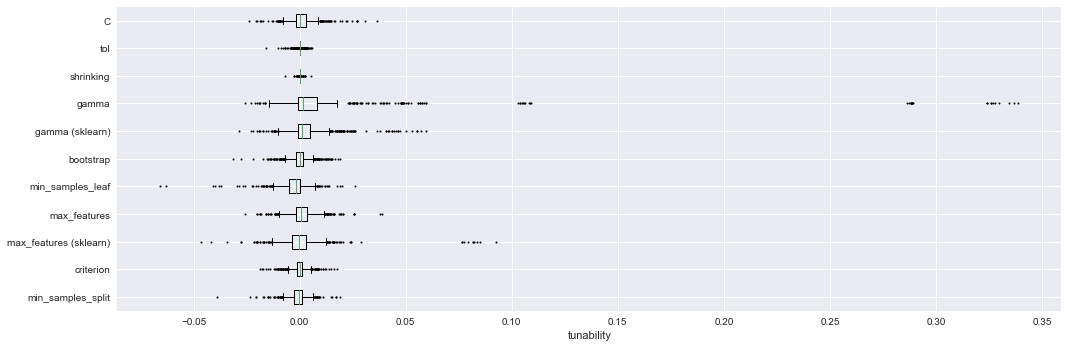

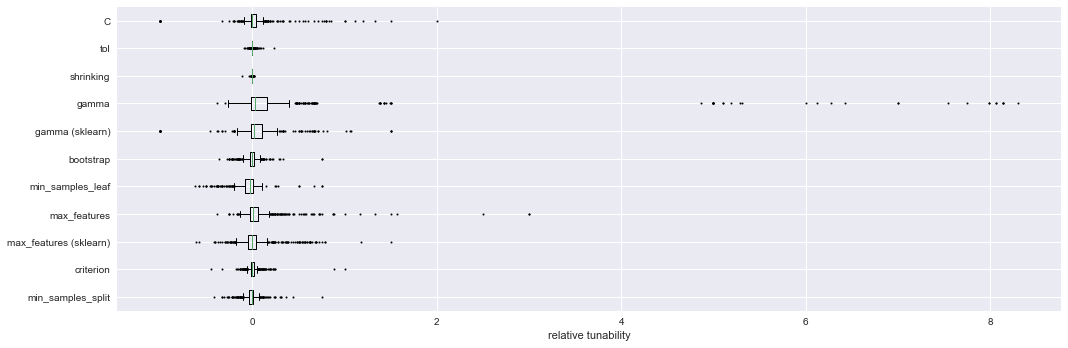

In [8]:
grid = False # put images on grid or not

if grid:
    cols = 1 # set nr columns in figure grid
    rows = 4
    plt.figure(figsize = (15*cols, 5*rows))
    index = 0
for scores, label in zip([all_scores, all_scores_rel], ['tunability', 'relative tunability']):
    if grid:
        index += 1
        plt.subplot(rows, cols, index)
    if not grid:
        plt.figure(figsize=(15,5))
    plt.boxplot(scores, labels = parameters, 
                flierprops = {'markersize' : 1, 'marker' : 'o', 'markeredgewidth' : 1},
               vert = False)
    plt.xlabel(label)
    plt.tight_layout()
    if not grid:
        #plt.savefig('02 figures/tunability/boxplot__%s.pdf' % (label), format = 'pdf')
        plt.show()
if grid:
    plt.show()

# Non-inferiority
Test whether the relative risk > 0.01.

## Relative risk

In [57]:
import scipy
delta = 0.01
alpha = 0.05

z_norm = scipy.stats.norm.ppf(1 - alpha)

equivalence = {}
for key, risk in risks.items():
    fixed = risk['fixed']
    non_fixed = risk['non_fixed']
    z1, p1, z2, p2 = hyperimp.equivalence(fixed, non_fixed, delta, alpha)
    equivalence[key] = {'test statistic 1' : z1, 'p-value 1' : p1}

# Holm-Bonferroni family wise error correction
# 1. order p-values from low to high
df = pd.DataFrame(equivalence).transpose().sort_values('p-value 1')
m = len(df)
# 2. let k be the minimum index such that p_k > alpha/(m + 1 - k)
k = 1
for key, row in df.iterrows():
    p = row['p-value 1']
    if p > alpha/(m + 1 - k):
        print("p_%s > %s/(%s + 1 - %s)" % (k, alpha, m, k))
        break
    else:
        k = k + 1
# reject all hypotheses h_i for i < k and do not reject all hypothesis h_i for i >= k
conclusions = ['H0 rejected: non-inferior'] * (k - 1) + ['H0 not rejected'] * (m - k + 1)
df['conclusion'] = conclusions

# display results
pd.options.display.precision = 2
display(df.sort_index())

p_8 > 0.05/(11 + 1 - 8)


p-value 1  test statistic 1  \
C                 None       3.40e-02              1.83   
bootstrap         None       1.11e-15              7.93   
criterion         None       1.11e-16              8.16   
gamma             hyperimp   1.00e+00             -8.24   
                  sklearn    1.00e+00             -4.61   
max_features      hyperimp   9.78e-01             -2.02   
                  sklearn    1.63e-04              3.59   
min_samples_leaf  None       0.00e+00             15.04   
min_samples_split None       0.00e+00             10.06   
shrinking         None       0.00e+00             20.49   
tol               None       0.00e+00             16.32   

                                           conclusion  
C                 None                H0 not rejected  
bootstrap         None      H0 rejected: non-inferior  
criterion         None      H0 rejected: non-inferior  
gamma             hyperimp            H0 not rejected  
                  sklearn             H0 not rejected  
max_features      hyperimp            H0 not rejected  
                  sklearn   H0 rejected: non-inferior  
min_samples_leaf  None      H0 rejected: non-inferior  
min_samples_split None      H0 rejected: non-inferior  
shrinking         None      H0 rejected: non-inferior  
tol               None      H0 rejected: non-inferior